In [34]:
import cv2
import sys
import numpy as np

def calculateSkyPositionField(gradientImage, threshold):
    expectedPos = np.full(gradientImage.shape[1],gradientImage.shape[0])
    for elem in range(gradientImage.shape[1]):
        borderPosition = np.argmax(gradientImage[:, elem] > threshold)
        if borderPosition > 0:
            expectedPos[elem] = borderPosition
    return expectedPos
    
def extractImageGradient(originalImage):
    grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
    sobelX = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1)
    #gradient = np.sqrt(sobelX**2 + sobelY**2)
    return np.hypot(sobelX, sobelY)

def extractMask(b, image):
    mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
    for xx, yy in enumerate(b):
        mask[yy:, xx] = 255

    return mask

def display_mask(b, image, color=[0, 0, 255]):
    result = image.copy()
    overlay = np.full(image.shape, color, image.dtype)
    cv2.addWeighted(
        cv2.bitwise_and(overlay, overlay, mask=make_mask(b, image)),
        1,
        image,
        1,
        0,
        result
    )
    cv2.imshow("Result", result)
    cv2.waitKey()


def partial_sky_region(bopt, thresh4):
    return np.any(np.diff(bopt) > thresh4)
    
def no_sky_region(bopt, thresh1, thresh2, thresh3):
    border_ave = np.average(bopt)
    asadsbp = np.average(np.absolute(np.diff(bopt)))

    return border_ave < thresh1 or (border_ave < thresh2 and asadsbp > thresh3)

def energy(b_tmp, image):
    sky_mask = extractMask(b_tmp, image)

    ground = np.ma.array(
        image,
        mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)
    ).compressed()
    sky = np.ma.array(
        image,
        mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)
    ).compressed()
    ground.shape = (ground.size//3, 3)
    sky.shape = (sky.size//3, 3)

    sigma_g, mu_g = cv2.calcCovarMatrix(
        ground,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    sigma_s, mu_s = cv2.calcCovarMatrix(
        sky,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )

    y = 2

    return 1 / (
        (y * np.linalg.det(sigma_s) + np.linalg.det(sigma_g)) +
        (y * np.linalg.det(np.linalg.eig(sigma_s)[1]) +
            np.linalg.det(np.linalg.eig(sigma_g)[1]))
    )
    

def calculateOptimalSkyBorderPosition(image,threshMin,threshMax,stepForSearch):
    gradientImage = extractImageGradient(image)
    samplePoints = ((threshMax - threshMin) // stepForSearch) + 1
    
    b_opt = None
    jn_max = 0

    for k in range(1, samplePoints + 1):
        t = threshMin + ((threshMax - threshMin) // samplePoints - 1) * (k - 1)

        b_tmp = calculateSkyPositionField(gradientImage, t)
        jn = energy(b_tmp, image)

        if jn > jn_max:
            jn_max = jn
            b_opt = b_tmp

    return b_opt

def main():
    originalImage = cv2.imread("../Images/Cropped_Runway/runway.png")
    bopt = calculateOptimalSkyBorderPosition(originalImage,5,600,5)
     
    if no_sky_region(bopt, image.shape[0]/30, image.shape[0]/4, 5):
        display("No sky detected")
        return

    display_mask(bopt, image)

    if partial_sky_region(bopt, image.shape[1]/3):
        bnew = refine_sky(bopt, image)

        display_mask(bnew, image)

    
if __name__ == "__main__":
    main()

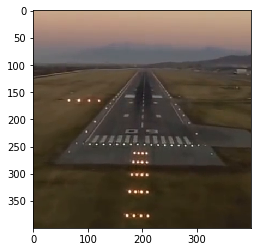

In [40]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

originalImage = cv2.imread("../Images/Cropped_Runway/runway.png")
plt.imshow(cv2.cvtColor(originalImage,cv2.COLOR_BGR2RGB), cmap = 'gray')
plt.show()

Number of sample points :  120


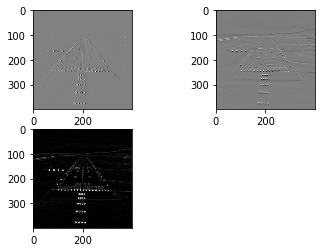

In [55]:
fig = plt.figure()

def extractImageGradient(originalImage):
    grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
    sobelX = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1)       
    fig.add_subplot(2, 2, 1)
    plt.imshow(sobelX, cmap = 'gray')    
    fig.add_subplot(2, 2, 2)
    plt.imshow(sobelY, cmap = 'gray')
    #gradient = np.sqrt(sobelX**2 + sobelY**2)
    return np.hypot(sobelX, sobelY)

def calculateOptimalSkyBorderPosition(image,threshMin,threshMax,stepForSearch):
    gradientImage = extractImageGradient(image)
    fig.add_subplot(2, 2, 3)
    plt.imshow(gradientImage, cmap = 'gray')
    samplePoints = ((threshMax - threshMin) // stepForSearch) + 1
    print("Number of sample points : ",samplePoints)
    optimalBorder = None
    jn_max = 0

    for k in range(1, samplePoints + 1):
        t = threshMin + ((threshMax - threshMin) // samplePoints - 1) * (k - 1)
        b_tmp = calculateSkyPositionField(gradientImage, t)
        jn = energy(b_tmp, image)
        if jn > jn_max:
            jn_max = jn
            b_opt = b_tmp
    return b_opt

optimalBorder = calculateOptimalSkyBorderPosition(originalImage, 5, 600, 5)